# Final Project
## Section 1.1: Trajectory Analysis

### Objective: 

Evaluate a model to predict trajectory of a ballistic missile using Forward Euler and Crank Nicolson Methods.


### Disclaimer: 

All information obtained regarding the physical or other characteristics of this system has been obtained from available published materials online and in writing. 

### Import Libraries

In [20]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy import pi
plt.rcParams['axes.grid'] = True

### Define Variables

Following values obtained and/or estimated using https://en.missilery.info/missile/trident2

In [23]:

C_D = 0.295 / 2 # Assumed to be the shape of a bullet + aerospike decreasing drag by 50% 
Tol = 0.1

# Define size dimensions of rocket motor

Diameter = D = 2.11 # Outer diameter of first stage (assumed low thickness such that D_inner ~ D)
Radius = Rad = D / 2 # Abbreviated as Rad instead of R, which is the gas constant
Z = 6.720 # height of first stage in meters
A = pi * Rad**2 # Area of rocket interior, equivalent as well to the frontal surface area of the rocket


In [25]:
# Define mass dimensions of rocket motor

S_Mass = 59068 # kg, mass of the fuelled rocket with all three stages
S1_Mass = 37918 # kg, mass of the fuelled first stage

Fuel_Fraction = 0.616 # Fractional share of entire FUELLED rocket's mass by first stage fuel
MFuel_0 = Fuel_Fraction * S_Mass # Starting fuel mass of first stage
m = S1E_Mass = S1_Mass - MFuel_0 # Mass of empty fuel stage 
rho_P = MFuel_0 / (Z * np.pi * Radius **2)

print("Starting Fuel (kg):", MFuel_0)
print("Chamber Mass (kg):", m)
print("Propellant Density (kg/m^3):", rho_P)

Starting Fuel (kg): 36385.888
Chamber Mass (kg): 1532.112000000001
Propellant Density (kg/m^3): 1548.491812314381


<img src="NEPE.png" width="500">

Chamber parameters were calculated using GUIPEP / PROPEP, a Propellant Evaluation Program developed by Martin Marietta to estimate specific heat ratios (k values), and effective molecular weight of exhaust based off of an assumed propellant composition and chamber pressure/temperature. I assumed the usage of NEPE propellant, which is composed roughly of 66% ammonium perchlorate, 8.2% Al2O3, 8.3% nitroglycerin, 8.3% nitrocellulose, 8.3% polyethylene glycol, and 0.82% HMX. To determine sensitivity of k estimations on assumed pressures, trials were run multiple times with varying pressures:

<img src="kGraph.png" width="500">

In [28]:
T_C = 1600
MWEff = 36385 / 1190 # Total mass of propellant divided by the effective MW of gas exiting the nozzle, kmol
k = 1.15431 # Calculated using C_P and C_S values from JANAF
P_C = 6890.1 # Chamber pressure, kPa
P_0 = 101.325 # Atmospheric pressure, kPa
a = 1.26 # Constant for pressure
n = 0.4 # Exponent for pressure


rate = a / (100 * (100)**n * (1000)**n) * (P_C)**n

R = 8314 # J / kmol K
U_E = -np.sqrt(2 * T_C * (R/MWEff)*(k/(k - 1))*(1 - (P_0/P_C)**((k - 1)/k)))

print("Burn Rate: (m/s)", rate)
print("Exit Velocity (m/s):", U_E)


Burn Rate: (m/s) 0.004321761090596145
Exit Velocity (m/s): -1675.140347493681


### Functions for Atmospheric Density and Gravity

Gravity can be found analytically using the 

Atmospheric density can be estimated using an exponential fit to data obtained from: https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html

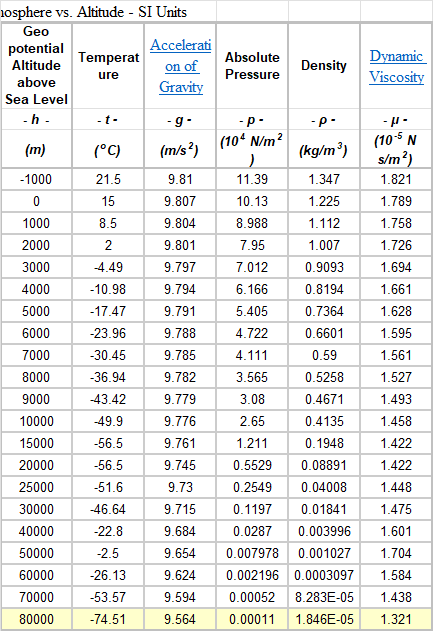

Gravity at h = 0:	 9.819945681891438
Gravity at h = 100 km:	 9.518784944285294
Gravity below 10% at sea level at:  18738174.22860383
Density below 1% at sea level at:  63095.7344480193


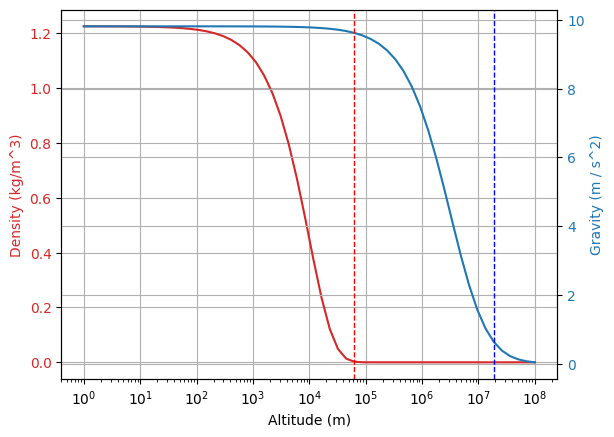

<Figure size 200x200 with 0 Axes>

In [32]:
def gravFunc(h):
    G_Constant = 6.67430 * 10**(-11) # m^3 / kg / s^2
    M_Earth = 5.972 * 10**24 # Kilograms
    R_Earth = 6371009 # Meters
    return G_Constant * M_Earth / (R_Earth + h)**2

print("Gravity at h = 0:\t", gravFunc(0))
print("Gravity at h = 100 km:\t", gravFunc(100000))

def atmRhoFunc(h, ρ0=1.225):
    return ρ0 * np.exp(-1e-04*h)

alt = np.logspace(0, 8, 56)
fig, ax1 = plt.subplots()
ax1.set_xscale('log')
color = 'tab:red'
ax1.set_xlabel('Altitude (m)')
ax1.set_ylabel('Density (kg/m^3)', color=color)
rhodata = atmRhoFunc(alt)
ax1.plot(alt, rhodata, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Gravity (m / s^2)', color=color)
gravdata = gravFunc(alt)
ax2.plot(alt, gravdata, color=color)
ax2.tick_params(axis='y', labelcolor=color)

FoundG = False
FoundD = False
for i in range(len(gravdata)):
    if gravdata[i] < gravdata[0]/10 and FoundG == False:
        P01PointGrav = alt[i]
        FoundG = True
    if rhodata[i] < rhodata[0] / 100 and FoundD == False:
        P001PointRho = alt[i]
        FoundD = True
    if FoundD and FoundG:
        break

print("Gravity below 10% at sea level at: ", P01PointGrav)
plt.axvline(x=P01PointGrav, color='b', lw=1, linestyle="dashed") 
print("Density below 1% at sea level at: ", P001PointRho)
plt.axvline(x=P001PointRho, color='r', lw=1, linestyle="dashed") 
import matplotlib
fig = plt.figure(figsize=(2,2))
#matplotlib.rcParams['figure.dpi'] = 500


plt.show()

### Preliminary Grain Area Analysis

As we begin our first trajectory analysis, we will need to make estimations for how area may expect to change over a given time. This will be estimated using more sophisticated, intensive analyses downstream, but for now a simple linear increase should suffice. The following data represents the change of area in a circular propellant grain over the course of flight:


Text(0.5, 0, 'Time (s)')

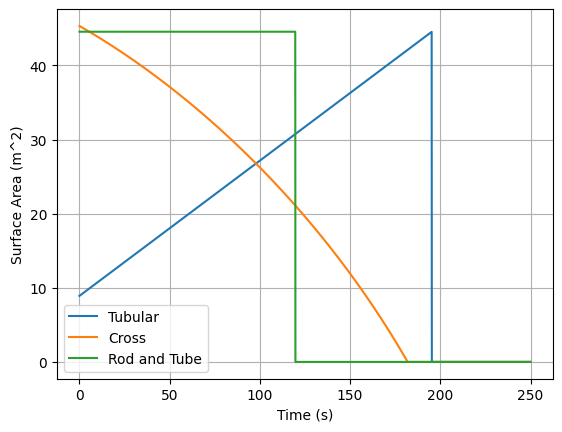

In [34]:
row = col = 200
timeburnt = []

def Circle(a, h, k, r0, val, prints = False):
    for c in range(col):
        for r in range(row):
            if c >= h - r0 and c <= h + r0:
                ylimH = k + np.sqrt(r0**2 - (c - h)**2)
                ylimL = k - np.sqrt(r0**2 - (c - h)**2)
                if r <= ylimH and r >= ylimL:
                    a[r][c] = val
    if prints == True:
        print("Starting Propellant Shape:")
        fig = plt.figure(figsize=(3,3))
        im = plt.imshow(Drawing, interpolation='none', aspect='auto', cmap="hot", vmin=0, vmax=100)
        plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False) 
        plt.show()
    return a
'''
def tubular(r0, rate, rmax):
    radius = r0
    t = 0
    data = []
    if rate < 0 or rmax < r0:
        print("Error with parameters")
        return [[],[]]
    while radius <= rmax: # Flight process
        data.append([t, 2 * pi * radius * Z])
        radius += rate
        t += 1
    
    data.append([t, 0])

    while radius > rate: # Termination of flight
        timeburnt.append(t)
        data.append([t, 2 * pi * radius * Z])
        radius = radius / 1.1
        
        t += 1

    print("Propellant Surface Area Profile:")
    data = np.array(data)
    plt.plot(data[:,0], data[:,1])
    plt.xlabel("Time (s)")
    plt.ylabel("Propellant Grain Surface Area (m^2)")
    plt.show()
    return np.array(data)
    '''
def tubular(r0, rate, rmax, time):
    A = (Z * 2 * pi * (r0 + time * rate))
    if A >= Z * 2 * pi * Rad:
        A = 0
    return A
    
def cross(r0, rate, rmax, time, bevel=True):
    if bevel == True:
        BEVEL =  np.sqrt(2 * rate**2 * time**2) - rate * time
    else:
        BEVEL = 0
    if 1-(r0 / 5 + time * rate)**2/Rad**2 > 0:
        A = 8 * Z * Rad * (np.sqrt(1-(r0 / 5 + time * rate)**2/Rad**2) - (r0 + rate * time) / Rad + BEVEL)
    else:
        A = 0
    if A < 0:
        A = 0
    return A

def rod_and_tube(r0, rate, rmax, time):
    margin = 2.55
    
    RA0 = r0*margin
    RB0 = r0*(margin - .1)
    P1 = 2 * pi * ((RA0) + rate*time) 
    P2 = 2 * pi * ((RB0) - rate*time)

    if P1 >= 2 * pi * Rad:
        P1 = 0    
    if P2 < 0:
        P2 = 0
    A = Z * (P1  + P2)
    return A

r0 = D/10

areaTimes = np.arange(0, 250, .1)
tubularAreas, crossAreas, rod_and_tube_Areas = [], [], []

for time in areaTimes:
    tubularAreas.append(tubular(r0, rate, D/2, time))
    crossAreas.append(cross(r0, rate, D/2, time))
    rod_and_tube_Areas.append(rod_and_tube(r0, rate, D/2, time))


plt.plot(areaTimes, tubularAreas, label = "Tubular")
plt.plot(areaTimes, crossAreas, label = "Cross")
plt.plot(areaTimes, rod_and_tube_Areas, label = "Rod and Tube")
plt.legend()
plt.ylabel("Surface Area (m^2)")
plt.xlabel("Time (s)")
#Areas = cross(r0, rate, D/2, 0.1)

### Preliminary Trajectory Analyses

We will now employ Forward Euler to make an initial estimation for our flight trajectory.

In [36]:
# Define initial values for ODEs

## h = Altitude of rocket (m)
## V = Velocity of rocket (m/s)
## M = Mass of rocket
## Mf = Mass of fuel (kg)
## g = Gravity, affected by altitude (m/s^2)
## ρ = Density, affected by altitude (kg/m^3)
Vdots = []
term1s = []
term2s = []
term3s = []
rhos = []
Cds = []
As = []
mis = []
mdots = []


def model(t, vals, Areas, fuelzero, n):
    h = vals[0]
    V = vals[1]
    M = vals[2]
    Mf = vals[3]
    g = gravFunc(h)
    ρ = atmRhoFunc(h)
    if ρ > atmRhoFunc(0):
        ρ = atmRhoFunc(0)
    elif ρ < 0:
        ρ = 0
    if g > gravFunc(0):
        g = gravFunc(0)
    elif g < 0:
        g = 0
    
    hdot = V
    if fuelzero == False:
        mDot = -rho_P * np.array(Areas)[1, n] * rate
        
    else:
        mDot = 0
    Vdot = -g - 1/2 * ρ * V * abs(V) * C_D * A / M + mDot * U_E / M

    mfDot = mDot
    
    
    return np.array([hdot, Vdot, mDot, mfDot], dtype=object)



Starting Propellant Shape:


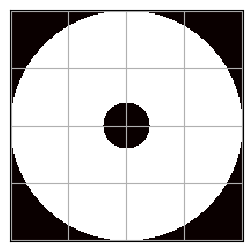

FE Start
FE Complete
CN Start
CN Complete


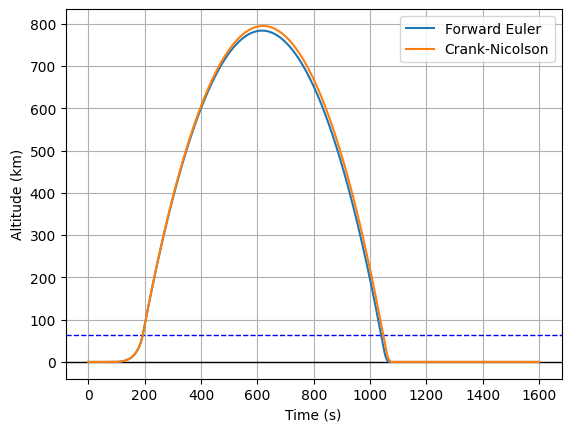

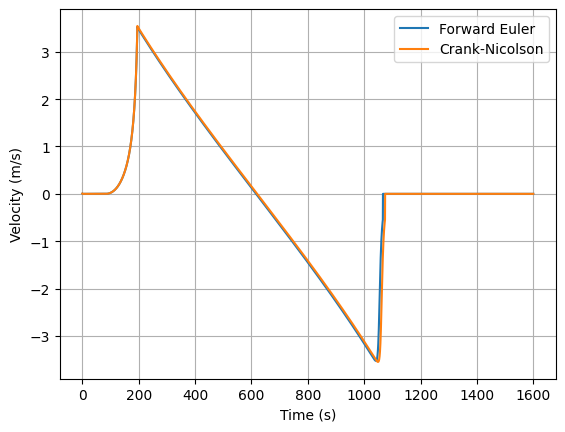

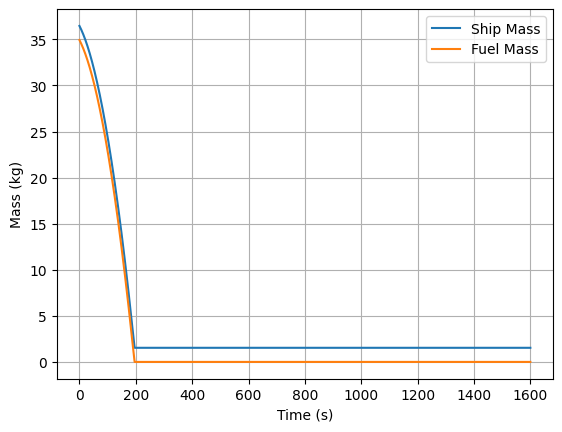

In [43]:
r0 = D/10

h_0 = 0
V_0 = 5
M_0 = S1_Mass - pi * r0**2 * Z * rho_P
Mf_0 = MFuel_0 - pi * r0**2 * Z * rho_P

IV = [h_0, V_0, M_0, Mf_0]
Drawing = Circle(-999 * np.ones((row + 1, col + 1)), int(row/2), int(col/2), int(row/2), 100)
Drawing = Circle(Drawing, int(row/2), int(col/2), int(r0 * row / D), 0, prints=True)


Areas = [areaTimes, crossAreas]
Areas = [areaTimes, rod_and_tube_Areas]

def interpolate(x, xList, yList):
    violated = False
    if x in xList:
        loc = np.where(xList == x)
        y = yList[loc]
    else:
        i = 0
        while xList[i] < x:
            i += 1
            if i == len(xList) - 1:
                #print("Outside of limit for x = ", x)
                violated = True
                break
        if violated == False:
            x1 = xList[i-1]
            x2 = xList[i]
            y1 = yList[i-1]
            y2 = yList[i]

            y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
        else:
            y = 0
    return y

def forward(f, times, IV, Areas):
    print("FE Start")
    n = len(times)
    m = len(IV)
    data = np.zeros((n, m))
    data[:][0] = IV
    fuelzero = False
    for i in range(n - 1):
        dt = times[1] - times[0]
        data[:][i+1] = data[:][i] + dt * f (times[i], data[:][i], Areas, fuelzero, i)
        if data[:][i+1][3] < 0: # Account for fuel levels dropping below 0
            data[:][i+1][3] = 0
            fuelzero = True
        if data[:][i+1][1] < 0 and data[:][i+1][0] < 5: # Kill negative velocities if below a groundlevel threshhold
            data[:][i+1][1] = 0
        if data[:][i+1][0] < 0: # Kill negative altitudes if below a groundlevel threshhold
            data[:][i+1][0] = 0  
    print("FE Complete")
    return data

def Crank(f, times, IV, Areas):
    print("CN Start")
    n = len(times)
    m = len(IV)
    data = np.zeros((n, m))
    data[:][0] = IV
    fuelzero = False
    for i in range(n - 1):
        dt = times[1] - times[0]
        def resfun(newdata):
            value = newdata - data[i,:] - 0.5 * dt * ( f ( i+1, newdata, Areas, fuelzero, i) + f (i, data[:][i], Areas, fuelzero, i) )
            return value.astype(float)
        data[:][i+1] = fsolve(resfun, data[:][i], full_output=0, )
        if data[:][i+1][3] < 0: # Account for fuel levels dropping below 0
            data[:][i+1][3] = 0
            fuelzero = True
        if data[:][i+1][1] < 0 and data[:][i+1][0] < 5: # Kill negative velocities if below a groundlevel threshhold
            data[:][i+1][1] = 0
        if data[:][i+1][0] < 0: # Kill negative altitudes if below a groundlevel threshhold
            data[:][i+1][0] = 0 
    print("CN Complete")
    return data

def plotter(datas, times, labs, index=0, xlab=" ", ylab=" ", legend=True, hlines=[], vlines=[], tmn = 0, tmx = 0, show=True):
    if tmx == 0:
        tmx = len(times)
    
    for line in hlines:
        if line == 0:
            co, width, style = 'k', 1, "solid"
        else:
            co, width, style = 'b', 1, "dashed"
        plt.axhline(y=line, color=co, lw=width, linestyle=style)
    for line in vlines:
        if line == 0:
            co, width, style = 'k', 1, "solid"
        else:
            co, width, style = 'b', 1, "dashed"
        plt.axvline(y=line, color=co, lw=width, linestyle=style)
    n = 0
    for datum in datas:
        plt.plot(times[tmn:tmx], datum[:,index][tmn:tmx]/1000, label=labs[n])
        n += 1
    if legend == True:
        plt.legend()
    if xlab != " " or ylab != " ":
        plt.xlabel(xlab)
        plt.ylabel(ylab)
    if show == True:
        plt.show()

matplotlib.rcParams['figure.dpi'] = 100    

tmin = 0
tmax = 1600
inc = .15


times = np.arange(0, int(tmax), inc)

tubularAreas = []
for time in times:
    tubularAreas.append(tubular(r0, rate, D/2, time))

Areas = [times, tubularAreas]

data = forward(model, times, IV, Areas)
data2 = Crank(model, times, IV, Areas)

datas = [data, data2]
labels = ["Forward Euler", "Crank-Nicolson"]

plotter(datas, times, labels, index=0, xlab="Time (s)", ylab="Altitude (km)", legend=True, 
        hlines=[P001PointRho/1000, 0], vlines=[], tmn = 0, tmx = int(tmax/inc))

plotter(datas, times, labels, index=1, xlab="Time (s)", ylab="Velocity (m/s)", legend=True, 
        hlines=[], vlines=[], tmn = 0, tmx = int(tmax/inc))

datas = [data]

plotter(datas, times, ["Ship Mass"], index=2, xlab="Time (s)", ylab="Mass (kg)", legend=True, 
        hlines=[], vlines=[], tmn = 0, tmx = int(tmax/inc), show=False)

plotter(datas, times, ["Fuel Mass"], index=3, xlab="Time (s)", ylab="Mass (kg)", legend=True, 
        hlines=[], vlines=[], tmn = 0, tmx = int(tmax/inc))


# Time Step Analysis

-26346.391388319484


Text(0, 0.5, 'Altitude (km)')

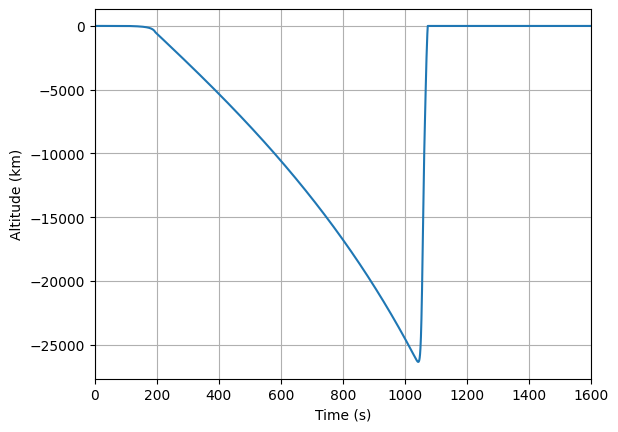

In [47]:
error = (data[:, 0] - data2[:, 0])
plt.plot(times, error)
print(min(error))
plt.xlim(0, 1600)
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")

FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete
FE Start
FE Complete
CN Start
CN Complete


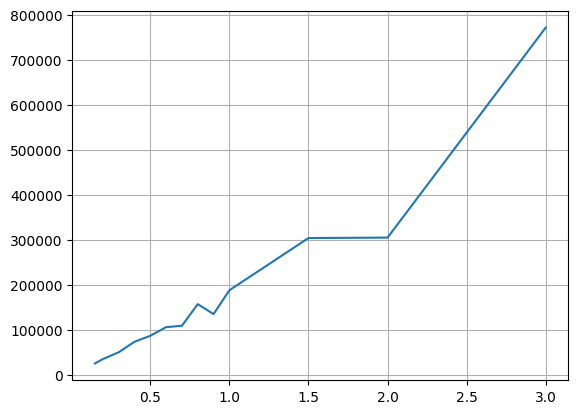

In [49]:
tmin = 0
tmax = 1600
errors = []
timesteps = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 3]
crankYs=[]
FEYs = []
for timestep in timesteps:
    times = np.arange(0, int(tmax), timestep)
    tubularAreas = []
    for time in times:
        tubularAreas.append(tubular(r0, rate, D/2, time))

    Areas = [times, tubularAreas]
    data = forward(model, times, IV, Areas)
    data2 = Crank(model, times, IV, Areas)
    datas = [data, data2]
    error = (data[:, 0] - data2[:, 0])
    crankYs.append(data2[:, 0])
    FEYs.append(data[:, 0])
    errorMax = max(abs(max(error)), abs(min(error)))
    errors.append(errorMax)
    
plt.plot(timesteps, errors)

Text(0, 0.5, 'Deviation (%)')

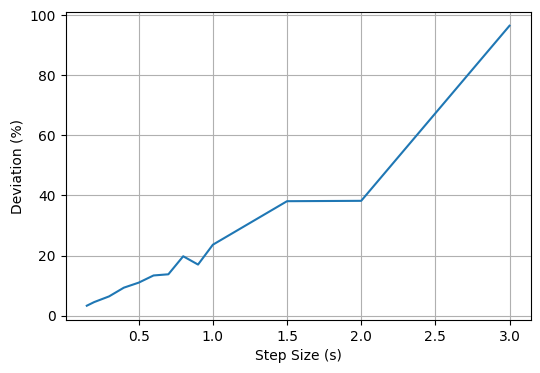

In [50]:
plt.figure(figsize=(6,4))
plt.plot(timesteps, np.array(errors)/8000)

plt.xlabel("Step Size (s)")
plt.ylabel("Deviation (%)")